In [1]:
import numpy as np
from numpy import loadtxt
import fitsio
import healpy as hp
import healsparse as hsp
import skyproj
import matplotlib.pyplot as plt
import Config
from astropy.table import Table
import os
from os import listdir
import scipy as sc
import treecorr
import copy

In [2]:
noise = 1000
res = 512
# deRes = 256
dirTrain = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/training/'

In [3]:
validPix = fitsio.read(dirTrain + 'Inter_Blue_<=26_Corrected_Map.fits')['PIXEL']
corrStar = fitsio.read(dirTrain + 'Inter_Blue_<=26_Corrected_Map.fits')['SIGNAL']
origStar = fitsio.read(dirTrain + 'Inter_Blue_<=26_Original_Map.fits')['SIGNAL']

In [4]:
ra, dec = hp.pixelfunc.pix2ang(res, validPix, nest = True, lonlat = True)
cropPix = np.where((ra >= 0) & (ra <= 370))[0]

In [5]:
map512 = np.full(12 * (res**2), hp.UNSEEN)
map512[validPix[cropPix]] = corrStar[cropPix]
# map512 = hp.ud_grade(map512, deRes, order_in = 'NESTED', order_out = 'NESTED')

In [6]:
origMap512 = np.full(12 * (res**2), hp.UNSEEN)
origMap512[validPix[cropPix]] = origStar[cropPix]
# origMap512 = hp.ud_grade(origMap512, deRes, order_in = 'NESTED', order_out = 'NESTED')
# validPix = np.where(map512 >= 0)[0]

In [7]:
nside_coverage = 32
hspMap512 = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=map512)
origHspMap512 = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=origMap512)

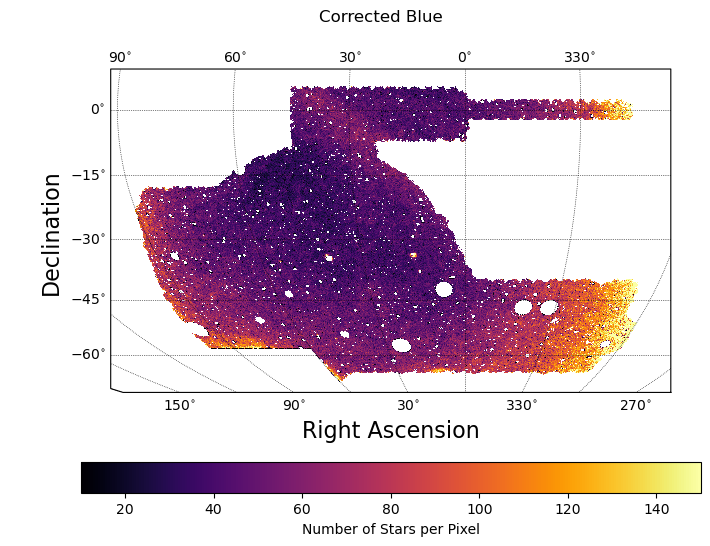

In [8]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspMap512, cmap = 'inferno')
plt.clim(10, 150)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Corrected Blue')
plt.show()

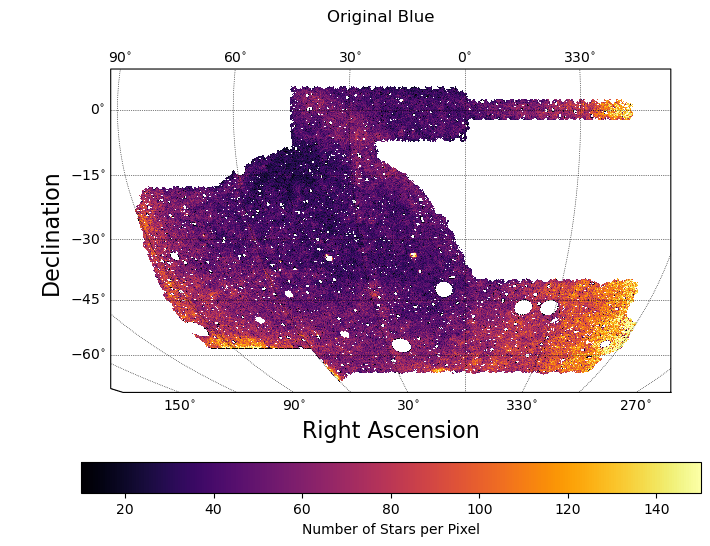

In [9]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(origHspMap512, cmap = 'inferno')
plt.clim(10, 150)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Original Blue')
plt.show()

In [10]:
min_sep = 0.4 * (np.pi / 180)
max_sep = 40 * (np.pi / 180)
nbins = 30

In [11]:
ra = ra * np.pi / 180
dec = dec * np.pi / 180

In [12]:
cat = treecorr.Catalog(ra=ra[cropPix], dec=dec[cropPix], ra_units='rad', dec_units='rad', w=map512[validPix[cropPix]])
nn = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
nn.process(cat)

In [13]:
randCat = treecorr.Catalog(ra=ra[cropPix], dec=dec[cropPix], ra_units='rad', dec_units='rad', w=np.random.normal(loc = np.average(map512[validPix[cropPix]]), scale = np.std(map512[validPix[cropPix]]), size = len(validPix[cropPix])))
rr = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
rr.process(randCat)

In [14]:
xi,varxi = nn.calculateXi(rr=rr)

In [15]:
ocat = treecorr.Catalog(ra=ra[cropPix], dec=dec[cropPix], ra_units='rad', dec_units='rad', w=origMap512[validPix[cropPix]])
onn = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
onn.process(ocat)

In [16]:
orandCat = treecorr.Catalog(ra=ra[cropPix], dec=dec[cropPix], ra_units='rad', dec_units='rad', w=np.random.normal(loc = np.average(origMap512[validPix[cropPix]]), scale = np.std(origMap512[validPix[cropPix]]), size = len(origMap512[validPix[cropPix]])))
orr = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
orr.process(orandCat)

In [17]:
oxi,ovarxi = onn.calculateXi(rr=orr)

In [18]:
r = nn.rnom * 180 / np.pi

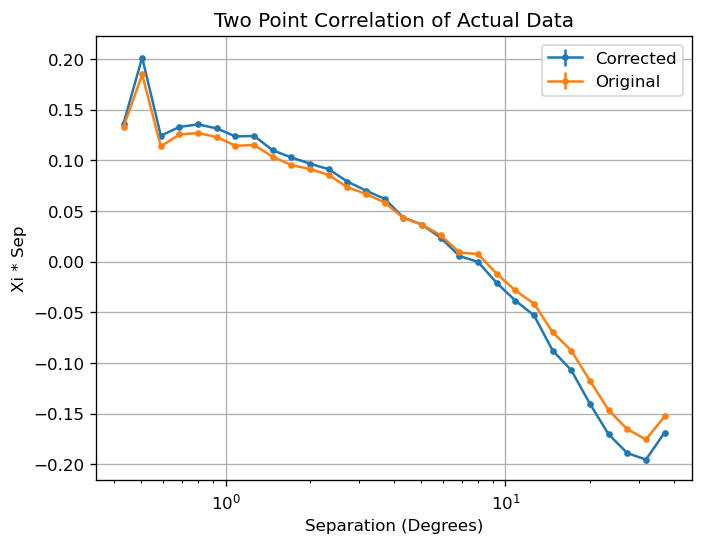

In [19]:
plt.figure(dpi = 120)
plt.errorbar(r, xi, yerr = np.sqrt(varxi), marker = '.', label = 'Corrected')
plt.errorbar(r, oxi, yerr = np.sqrt(ovarxi), marker = '.', label = 'Original')
plt.xlabel('Separation (Degrees)')
plt.xscale('log')
plt.ylabel('Xi * Sep')
plt.title('Two Point Correlation of Actual Data')
plt.legend()
plt.grid()
plt.show()

## Reverse Engineering an Original Map

In [20]:
weights = np.full(12*(res**2), 0.0)
weights[validPix] = 1.0

In [21]:
degrees = 1
sig = degrees * np.pi / 180

In [22]:
smoothWeights = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(weights, n2r = True), sigma = sig), r2n = True)

## Pseudo Code Algorithm
### Keep Data in Lists

1.) Load in each bin of star magnitudes separately.

2.) Apply corrections to each of these bins.

3.) Apply fracDet corrections to each of these bins.

4.) Generate smoothed individual maps.

5.) Smooth out the original maps, consider difference with the smoothed version as a noise distribution.

6.) Randomize this to get "noise" to apply at the end.

7.) Apply inverse corrections (1/correction) to each smoothed map.

8.) Add noise to each of these.

9.) Aggregate these into one final map, serve as a second "original" map.

In [23]:
origValidPix = fitsio.read(dirTrain + 'Valid_512_Pixels.fits')['PIXEL']

In [24]:
starDet = []
starDet.append(fitsio.read(dirTrain + 'Blue_<20_Original_Map.fits')['SIGNAL'])
starDet.append(fitsio.read(dirTrain + 'Blue_20-22_Original_Map.fits')['SIGNAL'])
starDet.append(fitsio.read(dirTrain + 'Blue_22-23_Original_Map.fits')['SIGNAL'])
starDet.append(fitsio.read(dirTrain + 'Blue_23-24_Original_Map.fits')['SIGNAL'])
starDet.append(fitsio.read(dirTrain + 'Blue_24-25_Original_Map.fits')['SIGNAL'])
starDet.append(fitsio.read(dirTrain + 'Blue_25-26_Original_Map.fits')['SIGNAL'])
starDet = np.array(starDet)

In [25]:
corrections = []
corrections.append(fitsio.read(dirTrain + 'Inter_Blue_<20_Corrections_Map.fits')['SIGNAL'])
corrections.append(fitsio.read(dirTrain + 'Inter_Blue_20-22_Corrections_Map.fits')['SIGNAL'])
corrections.append(fitsio.read(dirTrain + 'Inter_Blue_22-23_Corrections_Map.fits')['SIGNAL'])
corrections.append(fitsio.read(dirTrain + 'Inter_Blue_23-24_Corrections_Map.fits')['SIGNAL'])
corrections.append(fitsio.read(dirTrain + 'Inter_Blue_24-25_Corrections_Map.fits')['SIGNAL'])
corrections.append(fitsio.read(dirTrain + 'Inter_Blue_25-26_Corrections_Map.fits')['SIGNAL'])
corrections = np.array(corrections)

In [26]:
fracFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/fracdet/y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz'
fracData = fitsio.read(fracFile)
fracPix = fracData['PIXEL']
fracDet = fracData['SIGNAL']
fracMap = np.full(12*(4096**2), 0.0)
fracMap[fracPix] = fracDet
fracMap = hp.ud_grade(fracMap, 512, order_in = 'NESTED', order_out = 'NESTED')
fracPix = np.where(fracMap >= 0.75)[0]

In [27]:
corrInds = []
offset = 0
for i in np.arange(len(origValidPix)):
    if i - offset >= len(validPix):
        break
    if origValidPix[i] == validPix[i - offset]:
        corrInds.append(i)
    else:
        offset += 1
corrInds = np.array(corrInds)

In [28]:
fracInds = []
offset = 0
for i in np.arange(len(fracPix)):
    if i - offset >= len(validPix):
        break
    if fracPix[i] == validPix[i - offset]:
        fracInds.append(i)
    else:
        offset += 1
fracInds = np.array(fracInds)

In [29]:
# This process gets all of the arrays to be over the same pixels as the initial ones.

fracDet = fracMap[fracPix[fracInds]]
origStar = []
corrs = [] # Cropped corrections maps

for i in range(len(starDet)):
    origStar.append(starDet[i][corrInds])
    corrs.append(corrections[i][corrInds])
    origStar[i] = origStar[i] / fracDet
    
origStar = np.array(origStar)
corrs = np.array(corrs)

In [30]:
corrStar = []

for i in range(len(origStar)):
    corrStar.append(origStar[i] * corrs[i])

In [31]:
smoothCorrs = []

for i in range(len(corrStar)):
    fullCorrMap = np.full(12*(res**2), hp.UNSEEN)
    fullCorrMap[validPix] = corrStar[i]
    indSmoothCorr = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(fullCorrMap, n2r = True), sigma = sig), r2n = True)
    smoothCorrs.append(indSmoothCorr[validPix] / smoothWeights[validPix])
    
smoothCorrs = np.array(smoothCorrs)

In [32]:
randScaleCorrs = np.copy(corrs)
for randCorr in randScaleCorrs:
    scaleInds = np.random.choice(len(randCorr), size = int(0.5 * len(randCorr)))
    randCorr[scaleInds] = ((randCorr[scaleInds] - 1) * 2) + 1

In [33]:
randCorrs = np.copy(corrs)
for randCorr in randCorrs:
    randCorr = np.random.shuffle(randCorr)

In [34]:
mockOrig = []
for i in range(len(smoothCorrs)):
    mockOrig.append(smoothCorrs[i] / (corrs[i]))
    mockOrig[i] = np.random.poisson(mockOrig[i])
    #mockOrig[i] = mockOrig[i] * np.average(origStar[i]) / np.average(mockOrig[i]) # This will normalize it.
mockOrig = np.array(mockOrig)

for randCorr in randCorrs:
    randCorr = np.random.shuffle(randCorr)

mockCorr = []
for i in range(len(mockOrig)):
    mockCorr.append(mockOrig[i] * (((corrs[i] - 1)) + 1))
mockCorr = np.array(mockCorr)
    
fullMockOrig = np.full(12*(res**2), hp.UNSEEN)
fullMockOrig[validPix] = mockOrig[0]
for i in range(len(mockOrig) - 1):
    fullMockOrig[validPix] += mockOrig[i + 1]
    
fullMockCorr = np.full(12*(res**2), hp.UNSEEN)
fullMockCorr[validPix] = mockCorr[0]
for i in range(len(mockCorr) - 1):
    fullMockCorr[validPix] += mockCorr[i + 1]

In [35]:
realOrig = np.full(len(validPix), 0.0)
for i in range(len(origStar)):
    realOrig += origStar[i]
    
corrOrig = np.full(len(validPix), 0.0)
for i in range(len(corrStar)):
    corrOrig += corrStar[i]
    
fullRealOrig = np.full(12*(res**2), hp.UNSEEN)
fullRealOrig[validPix] = realOrig

fullRealCorr = np.full(12*(res**2), hp.UNSEEN)
fullRealCorr[validPix] = corrOrig

# smoothOrig = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(fullRealOrig, n2r = True), sigma = sig), r2n = True)
# smoothOrig = smoothOrig[validPix] / smoothWeights[validPix]

# diffOrig = realOrig - smoothOrig
# randDiffOrig = copy.deepcopy(diffOrig)
# np.random.shuffle(randDiffOrig)

In [36]:
mockHSP = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullMockOrig)
realHSP = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullRealOrig)
mockHSPCorr = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullMockCorr)
realHSPCorr = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullRealCorr)

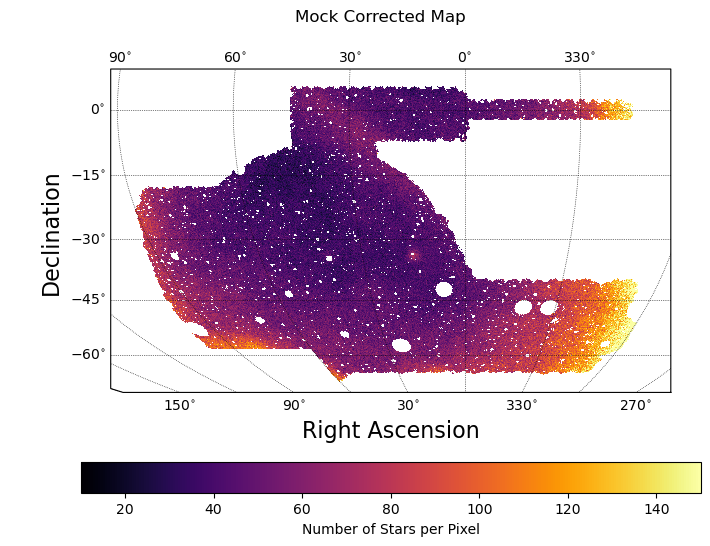

In [37]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(mockHSPCorr, cmap = 'inferno')
plt.clim(10, 150)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Mock Corrected Map')
plt.show()

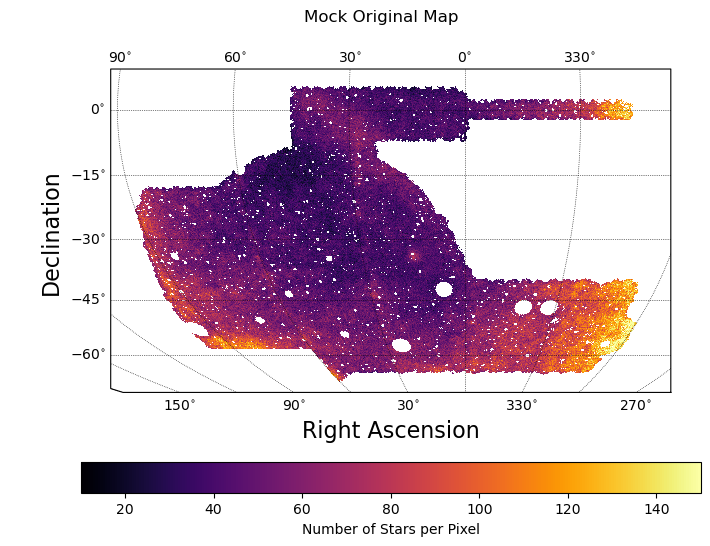

In [38]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(mockHSP, cmap = 'inferno')
plt.clim(10, 150)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Mock Original Map')
plt.show()

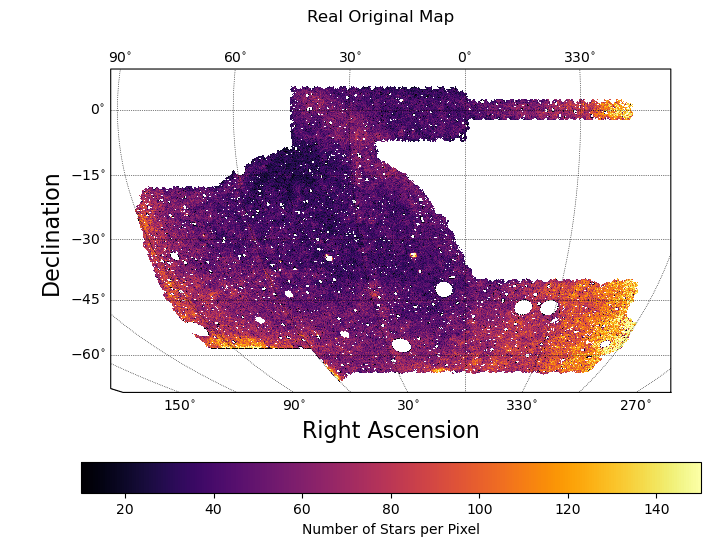

In [39]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(realHSP, cmap = 'inferno')
plt.clim(10, 150)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Real Original Map')
plt.show()

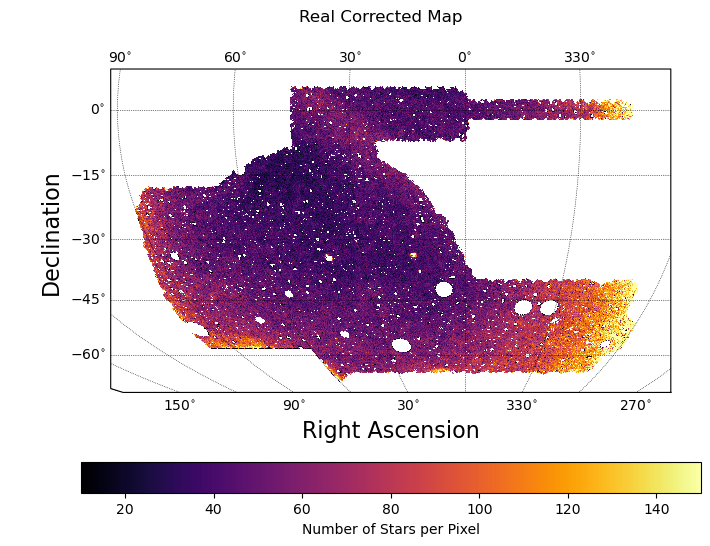

In [40]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(realHSPCorr, cmap = 'inferno')
plt.clim(10, 150)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Real Corrected Map')
plt.show()

In [41]:
cat = treecorr.Catalog(ra=ra, dec=dec, ra_units='rad', dec_units='rad', w=mockHSPCorr[mockHSPCorr.valid_pixels])
nn = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
nn.process(cat)

In [42]:
randCat = treecorr.Catalog(ra=ra, dec=dec, ra_units='rad', dec_units='rad', w=np.random.normal(loc = np.average(mockHSPCorr[mockHSPCorr.valid_pixels]), scale = np.std(mockHSP[mockHSP.valid_pixels]), size = len(validPix)))
rr = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
rr.process(randCat)

In [43]:
mxi,mvarxi = nn.calculateXi(rr=rr)

In [44]:
ocat = treecorr.Catalog(ra=ra, dec=dec, ra_units='rad', dec_units='rad', w=mockHSP[mockHSP.valid_pixels])
onn = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
onn.process(ocat)

In [45]:
orandCat = treecorr.Catalog(ra=ra, dec=dec, ra_units='rad', dec_units='rad', w=np.random.normal(loc = np.average(mockHSP[mockHSP.valid_pixels]), scale = np.std(mockHSP[mockHSP.valid_pixels]), size = len(validPix)))
orr = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
orr.process(orandCat)

In [46]:
moxi,movarxi = onn.calculateXi(rr=orr)

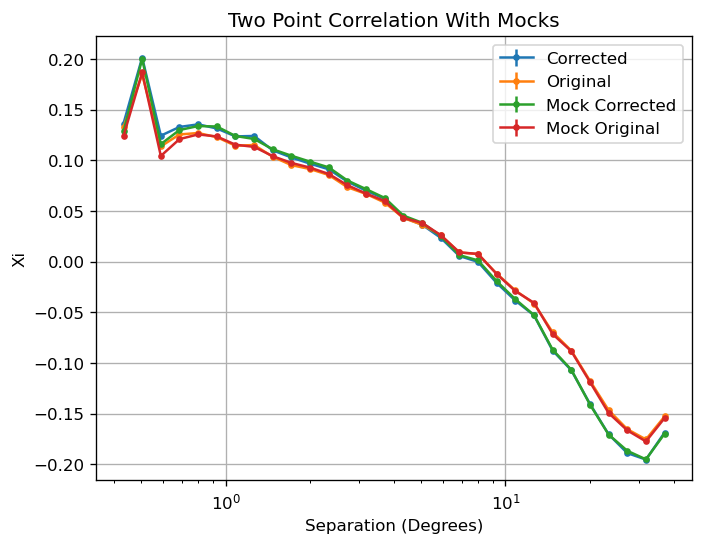

In [47]:
plt.figure(dpi = 120)
plt.errorbar(r, xi, yerr = np.sqrt(varxi), marker = '.', label = 'Corrected')
plt.errorbar(r, oxi, yerr = np.sqrt(ovarxi), marker = '.', label = 'Original')
plt.errorbar(r, mxi, yerr = np.sqrt(mvarxi), marker = '.', label = 'Mock Corrected')
plt.errorbar(r, moxi, yerr = np.sqrt(movarxi), marker = '.', label = 'Mock Original')
plt.xlabel('Separation (Degrees)')
plt.xscale('log')
plt.ylabel('Xi')
plt.title('Two Point Correlation With Mocks')
plt.legend()
plt.grid()
plt.show()

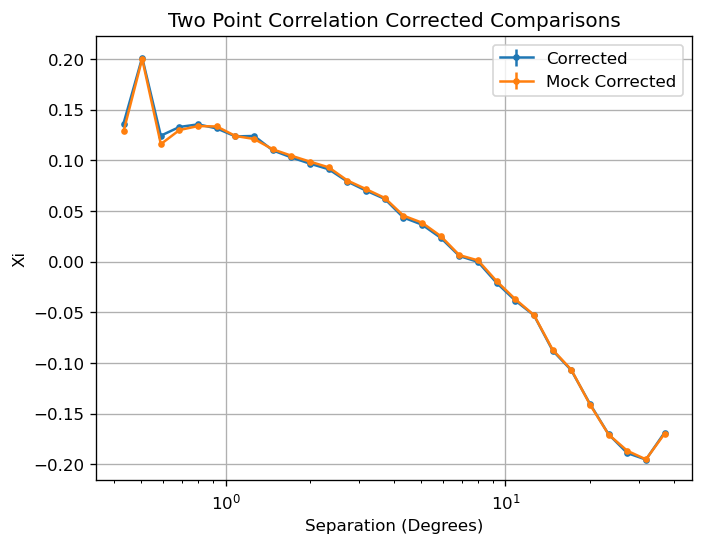

In [48]:
plt.figure(dpi = 120)
plt.errorbar(r, xi, yerr = np.sqrt(varxi), marker = '.', label = 'Corrected')
plt.errorbar(r, mxi, yerr = np.sqrt(mvarxi), marker = '.', label = 'Mock Corrected')
plt.xlabel('Separation (Degrees)')
plt.ylabel('Xi')
plt.xscale('log')
plt.title('Two Point Correlation Corrected Comparisons')
plt.legend()
plt.grid()
plt.show()

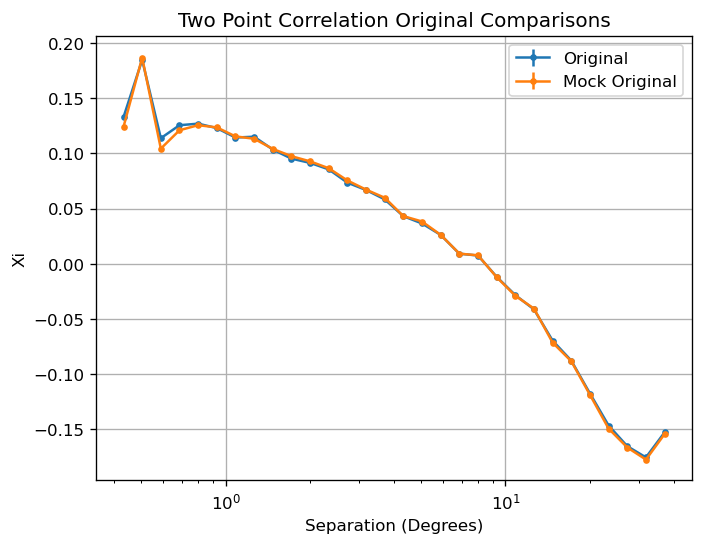

In [49]:
plt.figure(dpi = 120)
plt.errorbar(r, oxi, yerr = np.sqrt(ovarxi), marker = '.', label = 'Original')
plt.errorbar(r, moxi, yerr = np.sqrt(movarxi), marker = '.', label = 'Mock Original')
plt.xlabel('Separation (Degrees)')
plt.xscale('log')
plt.ylabel('Xi')
plt.title('Two Point Correlation Original Comparisons')
plt.legend()
plt.grid()
plt.show()

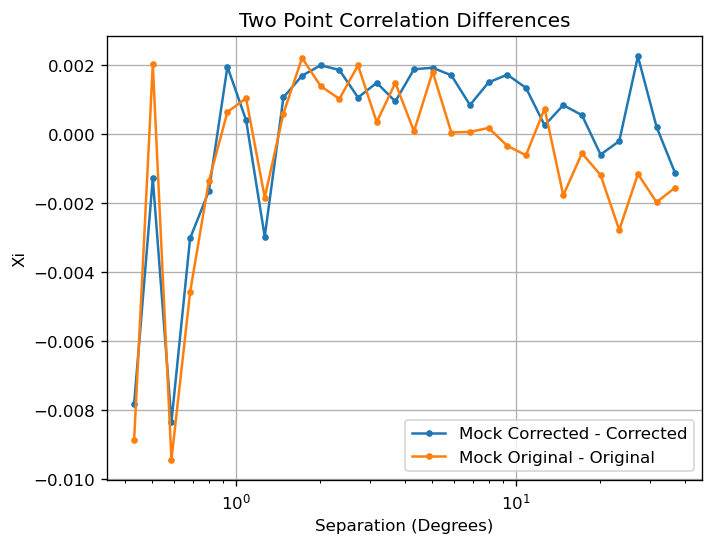

In [50]:
plt.figure(dpi = 120)
plt.plot(r, mxi - xi, marker = '.', label = 'Mock Corrected - Corrected')
plt.plot(r, moxi - oxi, marker = '.', label = 'Mock Original - Original')
plt.xlabel('Separation (Degrees)')
plt.ylabel('Xi')
plt.xscale('log')
plt.title('Two Point Correlation Differences')
plt.legend()
plt.grid()
plt.show()

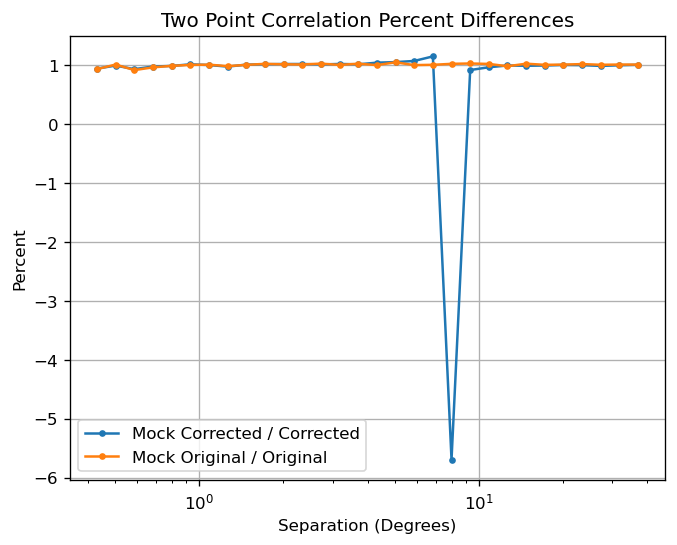

In [51]:
plt.figure(dpi = 120)
plt.plot(r, mxi/xi, marker = '.', label = 'Mock Corrected / Corrected')
plt.plot(r, moxi/oxi, marker = '.', label = 'Mock Original / Original')
plt.xlabel('Separation (Degrees)')
plt.ylabel('Percent')
plt.xscale('log')
plt.title('Two Point Correlation Percent Differences')
plt.legend()
plt.grid()
plt.show()

In [52]:
unif = []
for i in range(len(corrStar)):
    unif.append(np.full(len(corrStar[i]), np.average(corrStar[i])))
unif = np.array(unif)

In [53]:
unifOrig = []
for i in range(len(unif)):
    unifOrig.append(unif[i] / corrs[i])
    unifOrig[i] = np.random.poisson(unifOrig[i])
    # unifOrig[i] = unifOrig[i] * unif[i][0] / np.average(unifOrig[i]) # This will normalize it.
unifOrig = np.array(unifOrig)

unifCorr = []
for i in range(len(unifOrig)):
    unifCorr.append(unifOrig[i] * corrs[i])
unifCorr = np.array(unifCorr)
    
fullUnifOrig = np.full(12*(res**2), hp.UNSEEN)
fullUnifOrig[validPix] = unifOrig[0]
for i in range(len(unifOrig) - 1):
    fullUnifOrig[validPix] += unifOrig[i + 1]
    
fullUnifCorr = np.full(12*(res**2), hp.UNSEEN)
fullUnifCorr[validPix] = unifCorr[0]
for i in range(len(unifCorr) - 1):
    fullUnifCorr[validPix] += unifCorr[i + 1]

In [54]:
unifHSP = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullUnifOrig)
unifHSPCorr = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullUnifCorr)

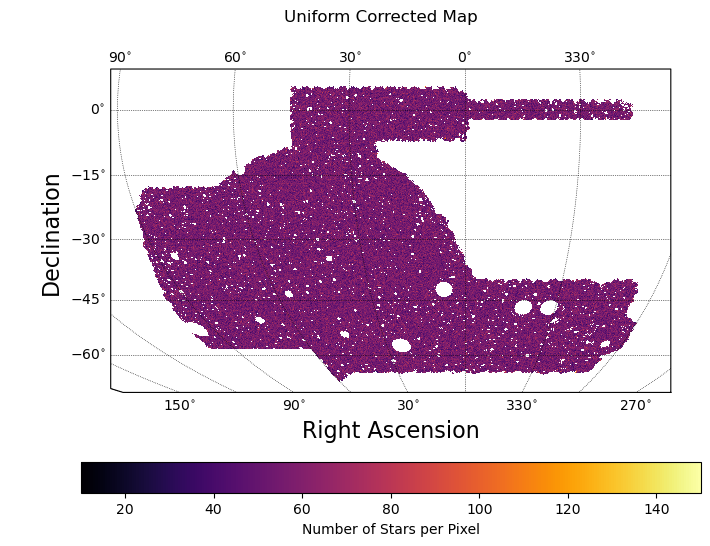

In [55]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(unifHSPCorr, cmap = 'inferno')
plt.clim(10, 150)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Uniform Corrected Map')
plt.show()

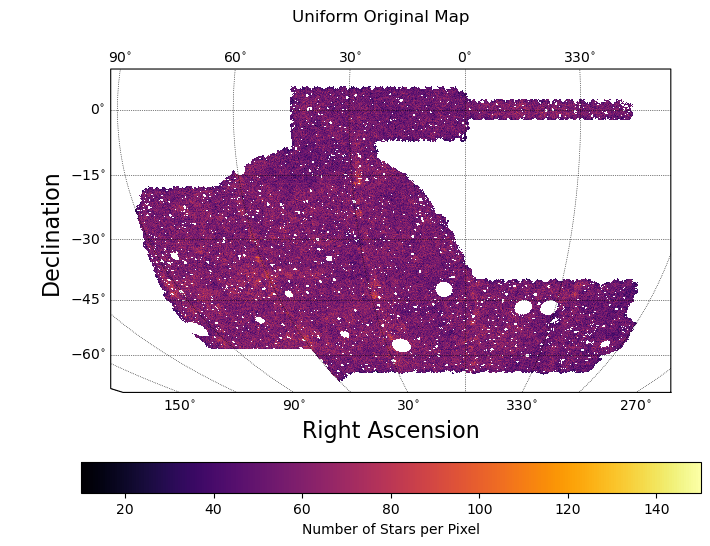

In [56]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(unifHSP, cmap = 'inferno')
plt.clim(10, 150)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Uniform Original Map')
plt.show()

In [57]:
cat = treecorr.Catalog(ra=ra, dec=dec, ra_units='rad', dec_units='rad', w=unifHSPCorr[unifHSPCorr.valid_pixels])
nn = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
nn.process(cat)

In [58]:
randCat = treecorr.Catalog(ra=ra, dec=dec, ra_units='rad', dec_units='rad', w=np.random.normal(loc = np.average(unifHSPCorr[unifHSPCorr.valid_pixels]), scale = np.std(unifHSP[unifHSP.valid_pixels]), size = len(validPix)))
rr = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
rr.process(randCat)

In [59]:
uxi,uvarxi = nn.calculateXi(rr=rr)

In [60]:
ocat = treecorr.Catalog(ra=ra, dec=dec, ra_units='rad', dec_units='rad', w=unifHSP[unifHSP.valid_pixels])
onn = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
onn.process(ocat)

In [61]:
orandCat = treecorr.Catalog(ra=ra, dec=dec, ra_units='rad', dec_units='rad', w=np.random.normal(loc = np.average(unifHSP[unifHSP.valid_pixels]), scale = np.std(unifHSP[unifHSP.valid_pixels]), size = len(validPix)))
orr = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
orr.process(orandCat)

In [62]:
uoxi,uovarxi = onn.calculateXi(rr=orr)

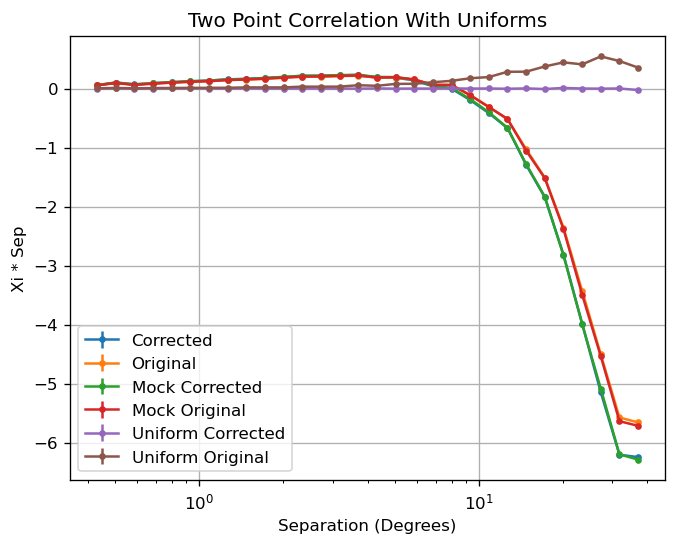

In [63]:
plt.figure(dpi = 120)
plt.errorbar(r, r * xi, yerr = np.sqrt(varxi), marker = '.', label = 'Corrected')
plt.errorbar(r, r * oxi, yerr = np.sqrt(ovarxi), marker = '.', label = 'Original')
plt.errorbar(r, r * mxi, yerr = np.sqrt(mvarxi), marker = '.', label = 'Mock Corrected')
plt.errorbar(r, r * moxi, yerr = np.sqrt(movarxi), marker = '.', label = 'Mock Original')
plt.errorbar(r, r * uxi, yerr = np.sqrt(uvarxi), marker = '.', label = 'Uniform Corrected')
plt.errorbar(r, r * uoxi, yerr = np.sqrt(uovarxi), marker = '.', label = 'Uniform Original')
plt.xlabel('Separation (Degrees)')
plt.xscale('log')
plt.ylabel('Xi * Sep')
plt.title('Two Point Correlation With Uniforms')
plt.legend()
plt.grid()
plt.show()

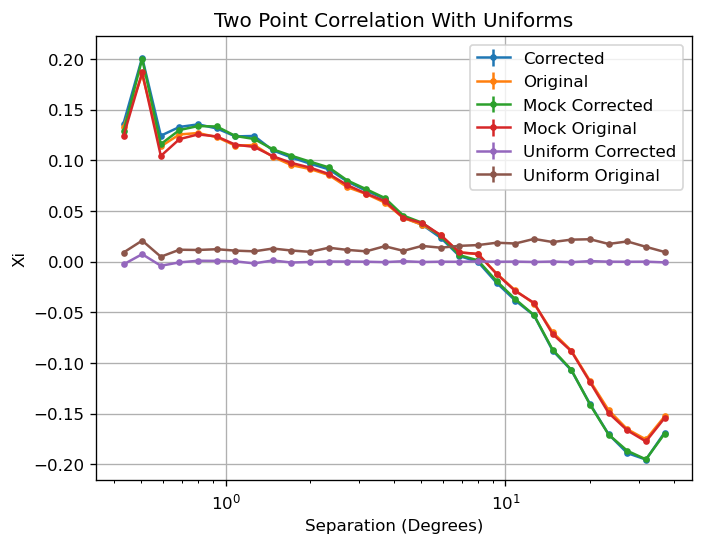

In [64]:
plt.figure(dpi = 120)
plt.errorbar(r, xi, yerr = np.sqrt(varxi), marker = '.', label = 'Corrected')
plt.errorbar(r, oxi, yerr = np.sqrt(ovarxi), marker = '.', label = 'Original')
plt.errorbar(r, mxi, yerr = np.sqrt(mvarxi), marker = '.', label = 'Mock Corrected')
plt.errorbar(r, moxi, yerr = np.sqrt(movarxi), marker = '.', label = 'Mock Original')
plt.errorbar(r, uxi, yerr = np.sqrt(uvarxi), marker = '.', label = 'Uniform Corrected')
plt.errorbar(r, uoxi, yerr = np.sqrt(uovarxi), marker = '.', label = 'Uniform Original')
plt.xlabel('Separation (Degrees)')
plt.xscale('log')
plt.ylabel('Xi')
plt.title('Two Point Correlation With Uniforms')
plt.legend()
plt.grid()
plt.show()

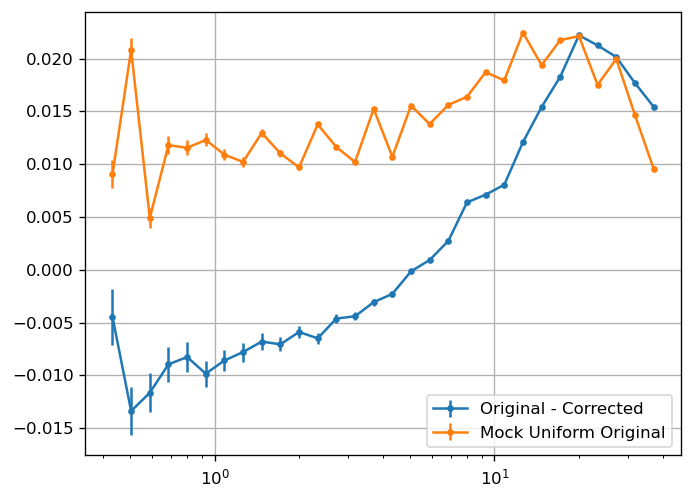

In [65]:
plt.figure(dpi = 120)
plt.errorbar(r, moxi - mxi, yerr = np.sqrt(varxi) + np.sqrt(ovarxi), marker = '.', label = 'Original - Corrected')
plt.errorbar(r, uoxi, yerr = np.sqrt(uovarxi), marker = '.', label = 'Mock Uniform Original')
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()